In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize

In [2]:
# HW4-1

# prepare a Bell state
# given a quantum circuit, qc, we will create a Bell pair 00+11 between qubits a and b
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a)
    qc.cx(a,b)

In [3]:
# HW4-2

# Alice will perform Bell-basis measurement between her qubit unknown (uk) and qubit a
# Given quantum computers measure in 0/1 basis, we need to perform the inverse transformation
# from 0/1 to the basis defined by the four Bell states  [see Homework 2]
# No measurement yet
def alice_bellgates(qc, uk, a):
    """Bell-basis transformation between Alice's unknown qubit and the half of the Bell pair shared with Bob"""
    qc.cx(uk,a)
    qc.h(uk)

In [4]:
# HW4-3

# Define alice's measurement
def alice_measure(qc, uk, a):
    """Measures qubits uk & a and records the results to classical bits 0-th and 1-th"""
    qc.measure(uk, crz)
    qc.measure(a, crx)

In [5]:
# HW4-4

# Bob needs to recover psi
# from results of ClassicalRegisters (crz & crx) to apply gates
def bob_gates(qc, qubit, crz, crx):
    # Here we use qc.gate(qubit).c_if(classicalregister,1) to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)


In [6]:
def psi_initialize(theta,phi):  # cos(theta)|0> + e^(i phi) sin(theta)|1>
    """obtain a gate to prepare an initial state"""
    psi=[np.cos(theta), np.sin(theta)* np.exp(1j* phi)]
    init_gate = Initialize(psi)
    init_gate.label = "init"
    return init_gate

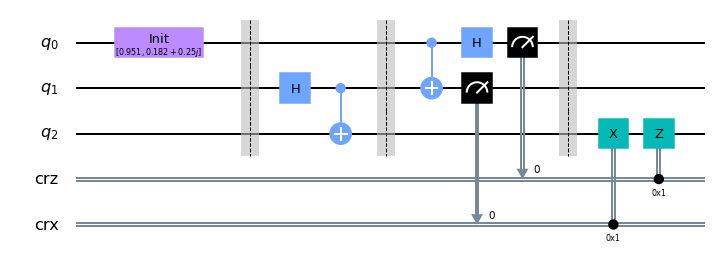

In [7]:
# Teleportation procedure
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
init_gate=psi_initialize(np.pi*0.1,np.pi*0.3)
qc.append(init_gate, [0]) 
qc.barrier()

## STEP 1
# share bell state [supposed to be shared in advance]
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Alice prepares Bell-state basis transformation
alice_bellgates(qc, 0, 1)

## STEP 3
# Alice measures her qubits 
alice_measure(qc, 0, 1)  # the classical results will be stored in crz and crx 
qc.barrier()

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw('mpl')

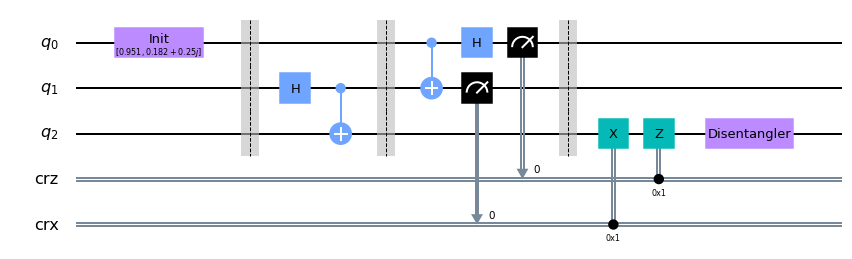

In [8]:
# in order to check, we can invert the init_gate and apply it to the qubit of Bob so it should be |0>
# Note that this inversion will somehow be named "disentangler"
inverse_init_gate = init_gate.gates_to_uncompute()
qc.append(inverse_init_gate,[2])
qc.draw('mpl')



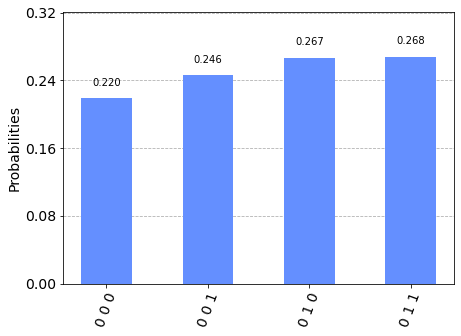

In [9]:
# Add ClassicalRegister
# to see the result of Bob's measurement
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw('mpl')

# Run simulation
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
# The counts are labeled->q_2 q_1 q_0: counts, ideally q_2 should be zero and 
# q_1 q_0's the counts should be equally distributed 
plot_histogram(counts)



In [10]:
# Let's check the probability of success
p=0
total=0
for key in counts.keys():
    total+= counts[key]
    if key[0]=='0':
        p=p+counts[key]
print('Probability of success = ',p/total)



Probability of success =  1.0


# Postponement of measurement 
# Instead of Alice performs measurement, if Alice and Bob can apply controlled gates, then they can postpone the measurement till the end

# Given that the third qubit (qubit 2) after the inversion is returned to 0, we can just measure it to verify the success

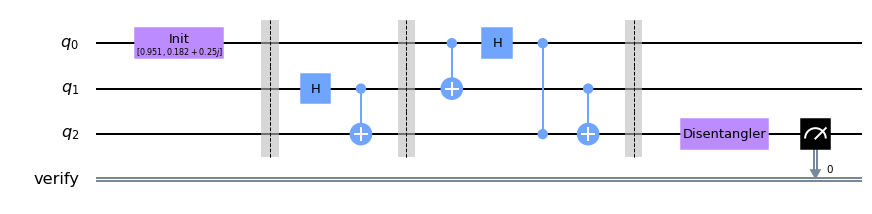

In [11]:
# Revised verification of the teleportation procedure
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
verify = ClassicalRegister(1, name="verify") # one classical
qc = QuantumCircuit(qr, verify)

## STEP 0
# First, let's initialize Alice's q0
init_gate=psi_initialize(np.pi*0.1,np.pi*0.3)
qc.append(init_gate, [0]) 
qc.barrier()

## STEP 1
# share bell state [supposed to be shared in advance]
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Alice prepares Bell-state basis transformation
alice_bellgates(qc, 0, 1)

## New STEP 3:
#
# HW-5 
# combine previous steps 3 and 4: Replace Alice measurement and Bob's action using controlled gates cz and cx 
qc.cz(0,2)
qc.cx(1,2)

### end of your code
qc.barrier()

## New STEP 4
# Bob applies inversion and measures its qubit
qc.append(inverse_init_gate,[2])
qc.measure(2,verify)

# Display the circuit
qc.draw('mpl')



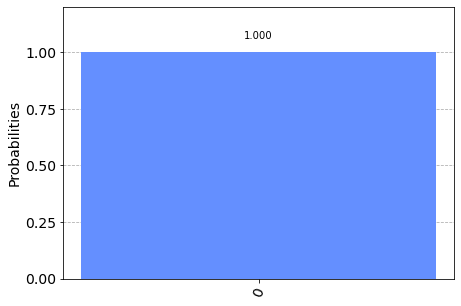

In [12]:
# Run simulation
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
# The counts should all be 0 (since we only measure the third qubit)
plot_histogram(counts)

In [13]:
# Let's check the probability of success
p=0
total=0
for key in counts.keys():
    total+= counts[key]
    if key[0]=='0':
        p=p+counts[key]
print('Probability of success = ',p/total)

Probability of success =  1.0


In [14]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.2',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.9.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.21.0'}